In [11]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# --------------------
# CONFIG
# --------------------
DATA_PATH = "../DATA/Combined_UVA_Tuition_Cleaned.csv"
OUT_DIR   = "../OUTPUT/06_piecewise_trend/"
COL_YEAR  = "Year_Start"
COL_GAP   = "Tuition_Gap"

TEST_YEARS        = 10
FORECAST_END_YEAR = 2030

os.makedirs(OUT_DIR, exist_ok=True)


In [4]:
# --------------------
# Utils
# --------------------
def mape(y_true, y_pred) -> float:
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.where(y_true == 0, 1e-9, np.abs(y_true))
    return float(np.mean(np.abs((y_true - y_pred) / denom)) * 100.0)

def r2(y_true, y_pred) -> float:
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot) if ss_tot != 0 else np.nan

def hinge(x, k):
    # (x - k)+
    return np.maximum(0.0, x - k)

def design_matrix(years, knots):
    """
    Build X = [1, year, (year - k1)+, (year - k2)+, ...]
    years: 1D array of year numbers
    knots: iterable of float/int knot positions (can be empty)
    """
    years = np.asarray(years, dtype=float)
    cols = [np.ones_like(years), years]  # intercept and global slope
    for k in knots:
        cols.append(hinge(years, float(k)))
    X = np.column_stack(cols)
    return X

def fit_ols_bic(X, y):
    model = sm.OLS(y, X)
    fit = model.fit()
    return fit, fit.bic

In [5]:
# --------------------
# Load & split
# --------------------
df = pd.read_csv(DATA_PATH)
needed = [COL_YEAR, COL_GAP]
missing = [c for c in needed if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

df[COL_YEAR] = pd.to_numeric(df[COL_YEAR], errors="coerce").astype("Int64")
df[COL_GAP]  = pd.to_numeric(df[COL_GAP],  errors="coerce")
df = df.dropna(subset=[COL_YEAR, COL_GAP]).sort_values(COL_YEAR).reset_index(drop=True)

years_all = df[COL_YEAR].to_numpy(dtype=int)
y_all     = df[COL_GAP].to_numpy(dtype=float)

split_idx  = max(0, len(df) - TEST_YEARS)
train_years = years_all[:split_idx]
test_years  = years_all[split_idx:]
y_train     = y_all[:split_idx]
y_test      = y_all[split_idx:]

print(f"Train years: {train_years[0]}–{train_years[-1]} | Test years: {test_years[0]}–{test_years[-1]}")



Train years: 1970–2013 | Test years: 2014–2023


In [6]:
# --------------------
# Candidate knot grid (choose from the interior to avoid degenerate hinges)
# We pick candidates every ~5 years across the middle 60% of the training span
# --------------------
tmin, tmax = int(train_years.min()), int(train_years.max())
span = tmax - tmin
inner_lo = tmin + int(0.2 * span)
inner_hi = tmax - int(0.2 * span)
# every ~5 years inside the interior band
candidate_knots = [y for y in range(inner_lo, inner_hi + 1, 5)]
# ensure unique and sorted
candidate_knots = sorted(set(candidate_knots))

# Enumerate 0, 1, or 2 knots and choose by BIC on TRAIN
best_cfg = {"knots": tuple(), "bic": np.inf, "fit": None}
configs = [()]  # 0-knot (just linear)
configs += [(k,) for k in candidate_knots]  # 1-knot
# 2-knot combos, enforce k1 < k2
configs += [tuple(sorted(pair)) for pair in itertools.combinations(candidate_knots, 2)]

for knots in configs:
    X_tr = design_matrix(train_years, knots)
    try:
        fit, bic = fit_ols_bic(X_tr, y_train)
        if bic < best_cfg["bic"]:
            best_cfg = {"knots": knots, "bic": bic, "fit": fit}
    except Exception:
        continue

best_knots = best_cfg["knots"]
fit_tr = best_cfg["fit"]
print(f"Selected knots (by train BIC): {best_knots if best_knots else 'none'} | BIC={best_cfg['bic']:.2f}")


Selected knots (by train BIC): (1988, 2003) | BIC=669.04


In [7]:
# --------------------
# Evaluate on TEST
# --------------------
X_te = design_matrix(test_years, best_knots)
y_pred_te = fit_tr.predict(X_te)

score_r2   = r2(y_test, y_pred_te)
score_mape = mape(y_test, y_pred_te)

last_n = min(5, len(y_test))
if last_n > 0:
    dir_true = np.sign(np.diff(y_test[-(last_n+1):]))
    dir_pred = np.sign(np.diff(y_pred_te[-(last_n+1):]))
    dir_acc  = float((dir_true == dir_pred).mean())
else:
    dir_acc = np.nan

print(f"Piecewise Trend → Test R²={score_r2:.3f}, MAPE={score_mape:.2f}%, Direction(last5)={dir_acc:.2f}")

# Save test predictions
pd.DataFrame({
    "year": test_years,
    "gap_actual": y_test,
    "gap_pred_piecewise": y_pred_te
}).to_csv(f"{OUT_DIR}/piecewise_test_predictions.csv", index=False)


Piecewise Trend → Test R²=0.933, MAPE=1.93%, Direction(last5)=1.00


In [8]:
# --------------------
# Refit on FULL data with selected knots & Forecast to 2030
# --------------------
X_full = design_matrix(years_all, best_knots)
fit_full = sm.OLS(y_all, X_full).fit()

last_year = int(years_all[-1])
extra_steps = int(FORECAST_END_YEAR - last_year)

future_years = np.array([], dtype=int)
future_forecast = np.array([], dtype=float)

if extra_steps > 0:
    future_years = np.arange(last_year + 1, FORECAST_END_YEAR + 1, dtype=int)
    X_future = design_matrix(future_years, best_knots)
    future_forecast = fit_full.predict(X_future)
    pd.DataFrame({"year": future_years, "gap_forecast_piecewise": future_forecast}).to_csv(
        f"{OUT_DIR}/piecewise_future_forecast_2030.csv", index=False
    )

In [9]:
# --------------------
# Save metrics
# --------------------
pd.DataFrame([{
    "selected_knots": str(best_knots),
    "num_knots": len(best_knots),
    "train_BIC": best_cfg["bic"],
    "test_R2": score_r2,
    "test_MAPE": score_mape,
    "directional_accuracy_last5": dir_acc
}]).to_csv(f"{OUT_DIR}/piecewise_metrics.csv", index=False)

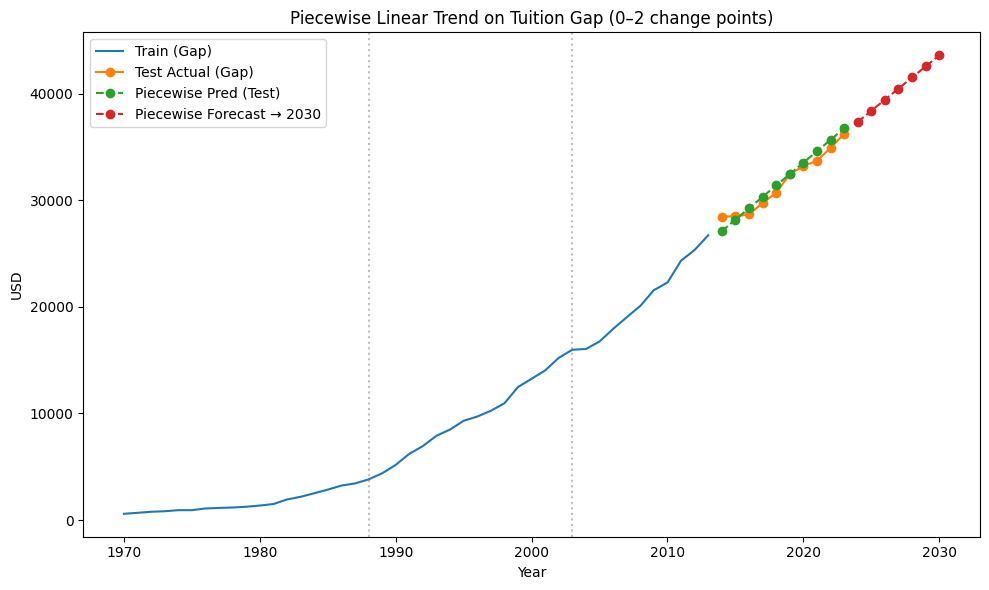

Saved: ../OUTPUT/06_piecewise_trend//piecewise_test_predictions.csv, ../OUTPUT/06_piecewise_trend//piecewise_future_forecast_2030.csv ../OUTPUT/06_piecewise_trend//piecewise_metrics.csv, ../OUTPUT/06_piecewise_trend//piecewise_gap_forecast.png


In [10]:
# --------------------
# Plot
# --------------------
plt.figure(figsize=(10,6))
plt.plot(train_years, y_train, label="Train (Gap)")
plt.plot(test_years, y_test, marker="o", label="Test Actual (Gap)")
plt.plot(test_years, y_pred_te, marker="o", linestyle="--", label="Piecewise Pred (Test)")

if future_years.size > 0:
    plt.plot(future_years, future_forecast, marker="o", linestyle="--", label="Piecewise Forecast → 2030")

# Visualize knots
for k in best_knots:
    plt.axvline(k, color="grey", linestyle=":", alpha=0.5)

plt.title("Piecewise Linear Trend on Tuition Gap (0–2 change points)")
plt.xlabel("Year"); plt.ylabel("USD")
plt.legend(); plt.tight_layout()
plt.savefig(f"{OUT_DIR}/piecewise_gap_forecast.png", dpi=200)
plt.show()

print("Saved:",
      f"{OUT_DIR}/piecewise_test_predictions.csv,",
      f"{OUT_DIR}/piecewise_future_forecast_2030.csv" if extra_steps > 0 else "(no future file)",
      f"{OUT_DIR}/piecewise_metrics.csv,",
      f"{OUT_DIR}/piecewise_gap_forecast.png")